In this notebook, we will see what it looks like when the rotor of a synchronous machine is oscillating.

#  Building a Jupyter notebook
## Getting started

First, let's import some packages we need to run this notebook. We must solve differential equations and animate plots we create with `matplotlib` package.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.ioff()
matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.rcParams["animation.html"] = "jshtml"
cmap = plt.get_cmap("tab10")
pi = np.pi

## Introduction

A synchronous generator rotates at some mechanical angular velocity $\omega_m$, a time derivative of its rotor position (angle):

$$ 
\frac{d\theta_m}{dt} = \omega_m (t) 
$$

where subscript $m$ denotes a mechanical quantity. Although we usually refer all quantities to the electrical side when conducting power system dynamic analyses, we will not do so here. That's because 50 or 60 Hz motion is too fast for the human eye to perceive. Instead, we will use a generator with many poles, reducing the mechanical speed needed to obtain 50 or 60 Hz electrical, and the motion will be nicely visible in the animations.

$\omega_m(t)$ depends on the balance between the mechanical torque of the turbine (how much power we are generating) and the generator's electrical load (how much power is consumed by the load connected to the generator). It also depends on the turbine type, load, speed governing mechanism, etc. If the turbine mechanical power in and generator electrical power out is perfectly balanced, the generator rotates at a constant speed. If there is any mismatch between the two, the generator will oscillate.

Let's not deal with generation-load balance for now and assume that we can describe the generator's speed function as follows:

$$
\omega_m = \omega_b^m + \Delta \omega^m_\mathrm{osc} - \omega^m_\mathrm{ref} = 2\pi \left( f_b^m + \Delta f^m_\mathrm{osc} - f^m_\mathrm{ref} \right)
$$

where $\omega_b^m$ is the base mechanical frequency (equal to 50 or 60 Hz divided by number of pole pairs), $\Delta \omega^m_\mathrm{osc}$ is the speed oscillation function and $f^m_\mathrm{ref}$ is the speed of the coordinate system through which we observe the motion (don't worry about it now, it will be explained a bit later).

Like most continuous dynamic systems, synchronous generators will behave similarly to a second-order system when disturbed, which is a damped sinusoidal behavior. So, we write the speed oscillation function accordingly:

$$
\Delta f^m_\mathrm{osc} = A e^{-Dt} \sin\left(2\pi f^m_\mathrm{osc}t\right)
$$

whre $A$ is the amplitude of oscillations, $D$ is the rate of decay and $f^m_\mathrm{osc}$ is a constant frequency of rotor oscillations.

To solve this ordinary differential equation numerically, we will use the `odeint` function from the `scipy` package. We also need to define the system of differential equations: 

In [3]:
def diff_eq(y, t, f, fref):
    theta = y
    dydt =  2 * pi * (f - fref + Afosc * np.sin(2 * pi * fosc * t) * np.exp(-t * damp))
    return dydt

## Simulation parameters

We need to define time-domain simulation parameters. Let's simulate rotor motion over 5 seconds with a time step of 10 ms:

In [4]:
#Simulation parameters
T = 5.0                                       # Total simulation duration [s]
dt = 0.01                                     # Integration step size and duration of each animation frame [s]
nsamples = int(T / dt) + 1                    # Number of samples
t = np.linspace(0, T, nsamples)               # Simulation time vector

## Generator parameters

Let's define a 20-pole 50 Hz generator. This means that the mechanical rotor frequency is 5 Hz. In other words, the rotor will complete one full turn (360 degrees) in 200 ms. During this interval, 10 fundamental frequency voltage sine waves will be induced at the stator terminals. 

Let's assume no oscillations for now, so we set $A$, $D$, and $f^m_\mathrm{osc}$ to $0$.

In [5]:
# Generator parameters
fb = 50                                       # Base electrical frequency [Hz]
pole_pairs = 10                               # Number of pole pairs [unitless]
fbm = fb / pole_pairs                         # Base mechanical frequency [mech. Hz]
wbm = 2 * pi * fbm                            # Base angular frequency [mech. rad / s]
Afosc = 0.0 / pole_pairs                      # Amplitude of rotor oscillations [mech. Hz]
fosc = 0.0 / pole_pairs                       # Frequency of rotor oscillations [mech. Hz]
damp = 0.0                                    # Damping factor of rotor oscillations [1/s]

## Solving differential equation
Let's solve the differential equation to obtain the angular position at every time instant. We will set $f^m_\mathrm{ref}$ to 0.0, corresponding to a stationary reference frame. We would see this if we observed the generator rotor standing beside it. We shall assume that the initial angle is 0 degrees. 

Rotor angle as a function of time is stored in the variable `thetam`, while rotor speed is stored in the variable `fm`.

In [22]:
# Solve differential equation to obtain (mechanical) rotor angle solution
fdq = 0.0   # Reference frame speed [mech. Hz] (0.0 for stationary reference frame)
thetam0 = 0.0
sol = odeint(diff_eq, thetam0, t, args=(fbm, fdq))
thetam = np.mod(sol[:, 0], 2 * pi)
fm = diff_eq(None, t, fbm, fdq) / (2 * pi)

## Plotting and animating rotor motion

First, let's draw the cross-section of a synchronous generator as two concentric shapes depicting the stator and rotor. Although this round rotor geometry is that of a turbogenerator, which usually has 2 to 4 poles (steam and gas turbines), we will also use it for hydro generators (generally more than 4 salient poles).

Next, we will position the coordinate system (direct and quadrature axis) such that its origin is at the centre of the rotation and the d-axis lays at 0 degrees (in line with the magnetic axis of field winding).

Then, we will initialize the time domain plots of rotor speed and angle by drawing an empty canvas.

We hide the last figure at position (1,1) because we don't need it.

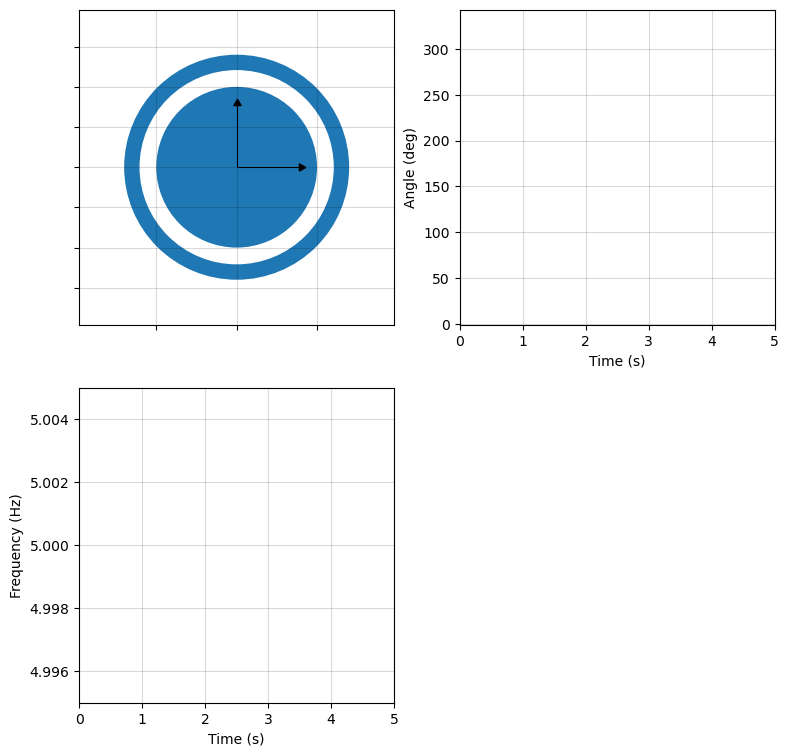

In [28]:
# Define stator and rotor dimensions
rr = 1.0
rsi = rr + 0.2
rso = rr + 0.4
ax_len = 0.8
rotor = plt.Circle((0, 0), rr, clip_on=False)
stator_outer = plt.Circle((0, 0), rso, clip_on=False)
stator_inner = plt.Circle((0, 0), rsi, clip_on=False, color='w')

# Draw stator and rotor cross-section
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
axes[0, 0].set_aspect('equal')
axes[0, 0].grid(visible=True, which='major', axis='both', color='k', alpha=0.15)
axes[0, 0].set(xlim=(-rso**2, rso**2), ylim=(-rso**2, rso**2))
axes[0, 0].set_yticklabels([])
axes[0, 0].set_xticklabels([])
axes[0, 0].add_patch(stator_outer)
axes[0, 0].add_patch(stator_inner)
axes[0, 0].add_patch(rotor)

# Initialize dq axis position
daxis, = axes[0, 0].plot([0.0, ax_len * rr], [0.0, 0.0], color='black', linewidth=0.75)
qaxis, = axes[0, 0].plot([0.0, 0.0], [0.0, ax_len * rr], color='black', linewidth=0.75)
darrow, = axes[0, 0].plot(ax_len * rr,  0.0, color='black', linewidth=0.75, marker=(3, 0, -90))
qarrow, = axes[0, 0].plot(0.0,  ax_len * rr, color='black', linewidth=0.75, marker=(3, 0, 0))

# Initialize time domain plot of rotor speed and angle 
tinst = []
yangle, yspeed = [], []
axes[1, 0].set(xlim=(0.0, T), ylim=(min(fm) - 0.005, max(fm) + 0.005))
axes[1, 0].set_aspect(np.diff(axes[1, 0].get_xlim())[0] / np.diff(axes[1, 0].get_ylim())[0])
axes[1, 0].grid(visible=True, which='major', axis='both', color='k', alpha=0.15)
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Frequency (Hz)')
speed_line, = axes[1, 0].plot([], [])
axes[0, 1].set(xlim=(0.0, T), ylim=(min(thetam * 180 / pi) - 1.0, max(thetam * 180 / pi) + 1.0))
axes[0, 1].set_aspect(np.diff(axes[0, 1].get_xlim())[0] / np.diff(axes[0, 1].get_ylim())[0])
axes[0, 1].grid(visible=True, which='major', axis='both', color='k', alpha=0.15)
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Angle (deg)')
angle_line, = axes[0, 1].plot([], [])

# Hide last subfigure
axes[-1, -1].axis('off');

Finally, to animate the rotor motion, we need to define a function that will update the plots and invoke `animation.FuncAnimation()` on the created figures. 

In [ ]:
# Update rotor position
def rotor_position(frame):
    time = t[frame]
    speed = fm[frame]
    theta = thetam[frame]
    tinst.append(time)
    yspeed.append(speed)
    yangle.append(theta * 180 / pi)
    r = ax_len * rr
    xd = r * np.cos(theta)
    yd = r * np.sin(theta)
    xq = r * np.cos(theta + pi / 2)
    yq = r * np.sin(theta + pi / 2)
    daxis.set_data([0.0, xd],[0.0, yd])
    qaxis.set_data([0.0, xq],[0.0, yq])
    darrow.set_data([xd], [yd])
    darrow.set_marker((3, 0, -90 + theta * 180 / pi))
    qarrow.set_data([xq], [yq])
    qarrow.set_marker((3, 0, 0 + theta * 180 / pi))
    speed_line.set_data(tinst, yspeed)
    angle_line.set_data(tinst, yangle)
    return daxis, qaxis, darrow, qarrow, speed_line, angle_line

# Animate rotor oscillations
ani = animation.FuncAnimation(fig=fig, func=rotor_position, frames=len(t), blit=True, interval=dt * 1000)
ani